Hello! My name is Andrew Yang, and I'm a first year Software Engineering student at the University of Waterloo. I'm excited to tackle real-world tasks pertaining to AI and data, and to both learn and apply skills to this project!

For this notebook, I will create a simple Conv2D model to classify a classic Tensorflow malaria dataset. NOTE: Running this notebook using google colab GPUs will significantly decrease runtime.

In [48]:
#import required modules
import tensorflow as tf
import numpy as np
import pandas
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import keras
#ignore any could not be resolved warnings, this should run.
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense,Flatten, InputLayer, BatchNormalization
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

In [ ]:
#import malaria dataset(will take some time if you haven't downloaded this dataset before(took me 5 minutes))
dataset, dataset_info = tfds.load('malaria', with_info = True, as_supervised=True, shuffle_files=True, split=['train'])

In [30]:
#Define a function to split the dataset into training, validation, and testing sets

def splits(TRAIN, VAL, TEST, dataset):
  size = len(dataset)
  train_dataset = dataset.take(int(TRAIN*size))

  val_dataset = dataset.skip(int(TRAIN * size))
  val_dataset = val_dataset.take(int(VAL*size))

  test_dataset = dataset.skip(int(VAL * size))

  return train_dataset, val_dataset, test_dataset


In [40]:
#These variables can be modified in order to change size of the respective sets
TRAIN = 0.8
VAL = 0.1
TEST = 0.1
train_dataset, val_dataset, test_dataset = splits(TRAIN, VAL, TEST, dataset[0])

Now that we have loaded the data and successfully split it into training, validation, and testing sets, we can process the data.

In [41]:
IM_SIZE = 224 #Target value for image size(The image will become 224x224 pixels)
#We will also normalize the data by dividing by 255.0, allowing for easier and more effective training
def resize_rescale(image, label):
  return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0, label

In [42]:
#rescale datasets(new shape=[224,224,3])
train_dataset = train_dataset.map(resize_rescale)
val_dataset = val_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)

To allow for efficient training, we should batch and prefetch the training data. Since this is a basic example, we will introduce slight randomization with a small buffer size of 8.

In [43]:
train_dataset = train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration= True).batch(32).prefetch(tf.data.AUTOTUNE)

In [17]:
val_dataset = val_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration= True).batch(32).prefetch(tf.data.AUTOTUNE)

Now we can define the model. Since we are looking at images, we desire a larger number of trainable parameters. A summary of the model is also provided for ease of viewing.

In [45]:
#This model outputs a confidence from 0-1 denoting how likely it is that the cell is parasitized,
#with one being most confident.
model = tf.keras.Sequential([
    InputLayer(shape=(IM_SIZE, IM_SIZE, 3)),
    #2d image processing
    tf.keras.layers.Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides = 2),

    tf.keras.layers.Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides = 2),
    #Flatten input to 1D for dense layers
    Flatten(),

    Dense(100, activation = "relu"),
    BatchNormalization(),
    Dense(10, activation = "relu"),
    BatchNormalization(),
    Dense(1, activation = "sigmoid")

])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 222, 222, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 109, 109, 16)   │           880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 109, 109, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 54, 54, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 46656)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100)            │     4,665,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,668,297 (17.81 MB)

 Trainable params: 4,668,033 (17.81 MB)

 Non-trainable params: 264 (1.03 KB)

In [19]:
model.compile(optimizer = Adam(learning_rate=0.01),
              loss = BinaryCrossentropy(),
              metrics = ['accuracy'])

IF you do not have a GPU you may wish to decrease the number of epochs in the following block of code. Conv2D networks, and more particularly training with 2D images, is quite intensive for a CPU. This will, of course, sacrifice some accuracy.

In [20]:
history = model.fit(train_dataset,validation_data = val_dataset, epochs = 10, verbose = 1)

Epoch 1/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 211s 296ms/step - accuracy: 0.8564 - loss: 0.3352 - val_accuracy: 0.9180 - val_loss: 0.2585
Epoch 2/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 138s 200ms/step - accuracy: 0.9335 - loss: 0.1948 - val_accuracy: 0.7539 - val_loss: 0.4105
Epoch 3/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 134s 194ms/step - accuracy: 0.9428 - loss: 0.1767 - val_accuracy: 0.9510 - val_loss: 0.1449
Epoch 4/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 137s 199ms/step - accuracy: 0.9473 - loss: 0.1590 - val_accuracy: 0.9256 - val_loss: 0.4017
Epoch 5/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 134s 194ms/step - accuracy: 0.9477 - loss: 0.1587 - val_accuracy: 0.8951 - val_loss: 0.4206
Epoch 6/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 139s 201ms/step - accuracy: 0.9529 - loss: 0.1403 - val_accuracy: 0.9459 - val_loss: 0.1766
Epoch 7/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 142s 205ms/step - accuracy: 0.9596 - loss: 0.1206 - val_accuracy: 0.9474 - val_loss: 0.1581
Epoch 8/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 133s 192ms/step - accuracy: 0.9626 -

We can view the running of our training as such:

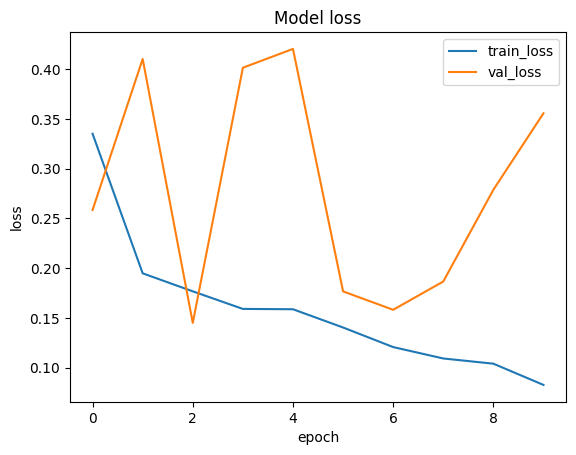

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

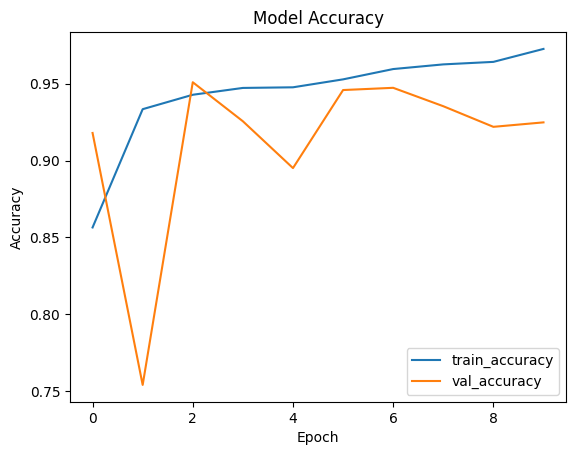

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

The plateauing of the validation accuracy might suggest the model is overfitting, which could be addressed by introducing more randomization, early stopping, etc.. To keep this notebook simple, the current accuracy is good enough.

We can now run our testing data:

In [44]:
#batch data
test_dataset = test_dataset.batch(1)
model.evaluate(test_dataset)

24803/24803 ━━━━━━━━━━━━━━━━━━━━ 231s 9ms/step - accuracy: 0.9482 - loss: 0.2078


[0.20783571898937225, 0.9482320547103882]

The model does pretty well on testing data too: Now, finally, we can view our model's predictions

In [ ]:
#define model to return uninfected if confidence < 0.5, else parasitized.
def parasite(x):
  if x < 0.5:
    return str('parasite')
  return str('uninfected')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


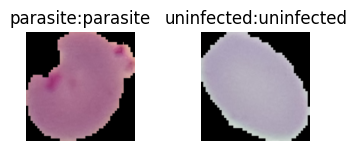

In [38]:
for i, (image, label) in enumerate(test_dataset.take(2)):
  ax = plt.subplot(3,3,i+1)
  plt.imshow(image[0])
  plt.title(str(parasite(label.numpy()[0])) + ":" + str(parasite(model.predict(image)[0][0])))
  plt.axis('off')